# Introduction

### This notebook focuses on detecting anomalies in financial markets using the XGBoost model and implementing an investment strategy based on the detected anomalies. The strategy uses key market indicators, such as price and moving averages, to generate buy, sell, or hold recommendations. Additionally, a chatbot is integrated to provide real-time insights and respond to user queries about the current strategy, anomalies, and market conditions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from flask import Flask, request, jsonify
import threading
from threading import Thread
import requests
import yfinance as yf

# Data Cleaning

In [13]:
# Load the dataset
dataset = pd.read_excel('../data/FinancialMarketData.xlsx', sheet_name='EWS')

# Calculate moving averages
dataset['VIX_moving_average'] = dataset['VIX'].rolling(window=7).mean()
dataset['BDIY_moving_average'] = dataset['BDIY'].rolling(window=7).mean()
dataset['CRY_moving_average'] = dataset['CRY'].rolling(window=7).mean()
dataset['Cl1_moving_average'] = dataset['Cl1'].rolling(window=7).mean()
dataset['USGG2YR_moving_average'] = dataset['USGG2YR'].rolling(window=7).mean()
dataset['GT10_moving_average'] = dataset['GT10'].rolling(window=7).mean()
dataset['DXY_moving_average'] = dataset['DXY'].rolling(window=7).mean()

# Calculate ratios
dataset['DXY_to_VIX'] = dataset['DXY'] / dataset['VIX']

# Calculate differences
dataset['VIX_diff'] = dataset['VIX'].diff()

# Add date-based features
dataset['Year'] = dataset['Data'].dt.year
dataset['Month'] = dataset['Data'].dt.month
dataset['Day'] = dataset['Data'].dt.day
dataset['DayOfWeek'] = dataset['Data'].dt.dayofweek

# Calculate correlation matrix and filter low correlation columns
correlation_matrix = dataset.corr()
low_cor_cols = correlation_matrix['Y'][abs(correlation_matrix['Y']) < 0.04].index

# Drop low-correlation columns
dataset_cleaned = dataset.drop(columns=low_cor_cols)

# Convert 'Data' column to datetime and set it as the index
dataset['Data'] = pd.to_datetime(dataset['Data'])  # Ensure the 'Data' column is in datetime format
dataset.set_index('Data', inplace=True)  # Set 'Data' as the index for alignment

# Assign the datetime index to the cleaned dataset
dataset_cleaned['Data'] = dataset.index  # Transfer the dates into dataset_cleaned
dataset_cleaned.set_index('Data', inplace=True)  # Set 'Data' as the index

# Download SPY data using yfinance for the same date range
spy_data = yf.download("SPY", start="2000-01-11", end="2021-04-20")

# Align SPY data with the cleaned dataset and fill missing values
dataset_cleaned['SPY'] = spy_data['Close'].reindex(dataset_cleaned.index, method='ffill')

# Verify the results
print(dataset_cleaned[['SPY']].head())
dataset_cleaned.describe()

print(dataset_cleaned.columns)

[*********************100%***********************]  1 of 1 completed

                  SPY
Data                 
2000-01-11  92.095390
2000-01-18  92.931969
2000-01-25  90.462273
2000-02-01  89.824936
2000-02-08  91.975914
Index(['Y', 'ECSURPUS', 'BDIY', 'CRY', 'DXY', 'JPY', 'GBP', 'Cl1', 'VIX',
       'GTDEM30Y', 'GTDEM10Y', 'GTDEM2Y', 'EONIA', 'GTITL30YR', 'GTITL10YR',
       'GTITL2YR', 'GTJPY30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTGBP30Y',
       'GTGBP20Y', 'LUMSTRUU', 'LMBITR', 'LUACTRUU', 'LF98TRUU', 'LG30TRUU',
       'LP01TREU', 'EMUSTRUU', 'LF94TRUU', 'MXUS', 'MXEU', 'MXJP', 'MXBR',
       'MXRU', 'MXIN', 'MXCN', 'VIX_moving_average', 'BDIY_moving_average',
       'CRY_moving_average', 'DXY_moving_average', 'DXY_to_VIX', 'VIX_diff',
       'Year', 'DayOfWeek', 'SPY'],
      dtype='object')


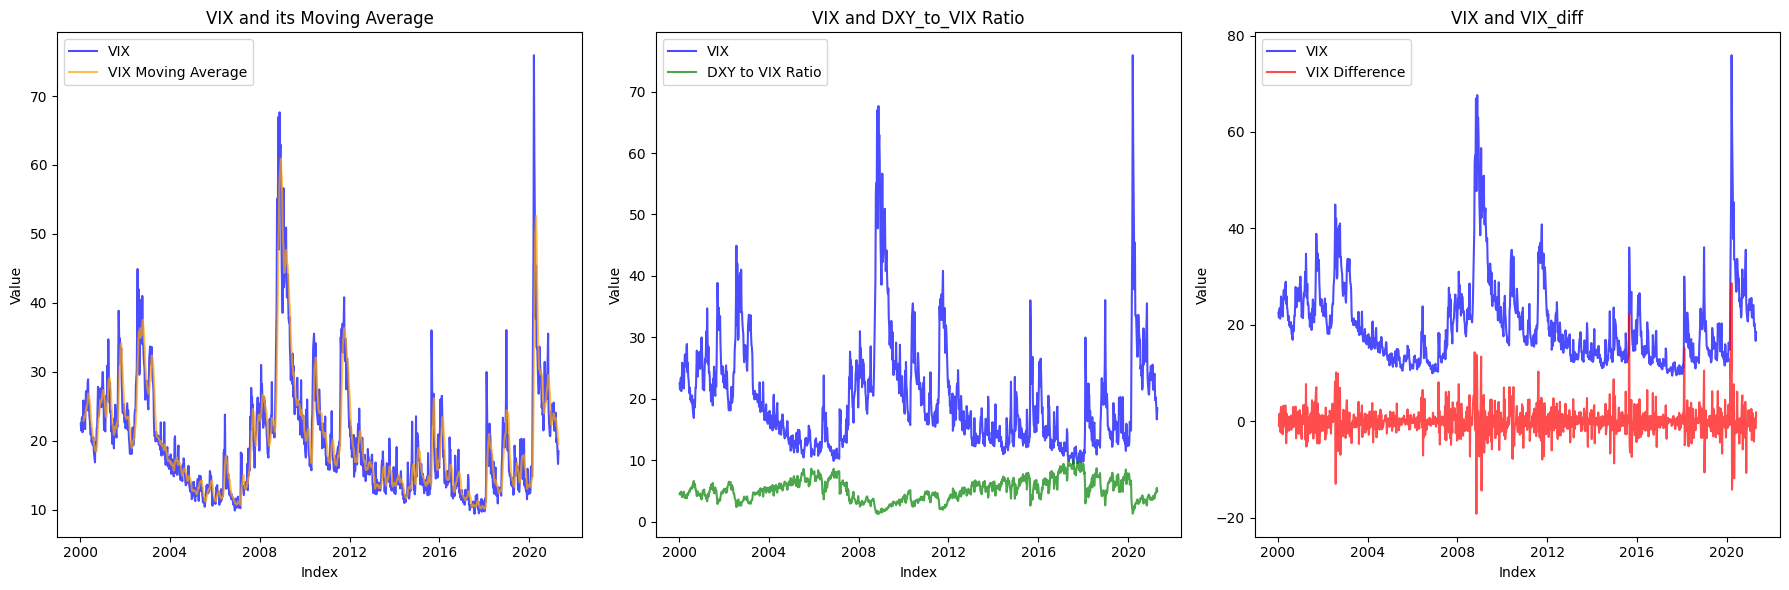

In [3]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot VIX and its Moving Average
axes[0].plot(dataset_cleaned['VIX'], label='VIX', alpha=0.7, color='blue')
axes[0].plot(dataset_cleaned['VIX_moving_average'], label='VIX Moving Average', alpha=0.7, color='orange')
axes[0].set_title("VIX and its Moving Average")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")
axes[0].legend()

# Plot VIX and its ratios (DXY_to_VIX)
axes[1].plot(dataset_cleaned['VIX'], label='VIX', alpha=0.7, color='blue')
axes[1].plot(dataset_cleaned['DXY_to_VIX'], label='DXY to VIX Ratio', alpha=0.7, color='green')
axes[1].set_title("VIX and DXY_to_VIX Ratio")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")
axes[1].legend()

# Plot VIX and its differences (VIX_diff)
axes[2].plot(dataset_cleaned['VIX'], label='VIX', alpha=0.7, color='blue')
axes[2].plot(dataset_cleaned['VIX_diff'], label='VIX Difference', alpha=0.7, color='red')
axes[2].set_title("VIX and VIX_diff")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")
axes[2].legend()

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


# Data Preperation For Training

In [4]:
X= dataset_cleaned.drop(columns=['Y'])
y=dataset_cleaned['Y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

## Handling Class Imbalance

In [5]:
class_counts = Counter(y_train)
negatives = class_counts[0]  # Normal class
positives = class_counts[1]  # Anomaly class

# Scale_pos_weight calcul
scale_pos_weight = negatives / positives
print(f"Scale Pos Weight: {scale_pos_weight}")


Scale Pos Weight: 3.649214659685864


## Training the XGBoost Classifier

In [6]:
# Model inisialization
model = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.25, 
    random_state=43, 
    scale_pos_weight=5
)

model.fit(X_train, y_train)

#  prediction model
y_pred = model.predict(X_test)

print("Classification Report :")
print(classification_report(y_test, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       177
           1       0.82      0.78      0.80        46

    accuracy                           0.92       223
   macro avg       0.88      0.87      0.87       223
weighted avg       0.92      0.92      0.92       223



# Investment Strategy Implementation

### In this section, we will define and implement a data-driven investment strategy based on the model's predictions.


In [7]:

def fetch_real_time_data(ticker="SPY"):
    """
    Fetch real-time data for the given ticker.
    Returns the last closing price and a DataFrame of the data.
    """
    real_time_data = yf.download(tickers=ticker, period="1d", interval="1m")  # Fetch last 1 day's data
    if not real_time_data.empty:
        latest_price = real_time_data['Close'].iloc[-1]  # Latest closing price
        return latest_price, real_time_data
    else:
        return None, None

def calculate_moving_average(real_time_data, window=7):
    """
    Calculate the moving average for the given window size.
    Returns the latest moving average value.
    """
    if real_time_data is not None:
        moving_average = real_time_data['Close'].rolling(window=window).mean().iloc[-1]
        return moving_average
    else:
        return None



In [8]:
def predict_anomaly(model, latest_price, moving_average):
    """
    Predict the probability of an anomaly using the model.
    Returns the anomaly probability.
    """
    # Convert inputs to float if they are not already
    try:
        latest_price = float(latest_price)
        moving_average = float(moving_average)
    except ValueError:
        raise ValueError("Price and moving average must be convertible to float.")

    # Prepare the feature set based on the model's requirements
    latest_features = pd.DataFrame({
        'price': [latest_price],
        'moving_average': [moving_average],
    })
    
    # Predict anomaly probability
    anomaly_prob = model.predict_proba(latest_features)[0, 1]  # Probability of the anomaly
    return anomaly_prob


In [9]:
def define_real_time_strategy(latest_data):
    """
    Define the buy/sell/hold strategy based on real-time data and anomaly detection.
    """
    if latest_data:
        price = float(latest_data['price'])  # Convert to scalar
        moving_average = float(latest_data['moving_average'])  # Convert to scalar
        anomaly_prob = float(latest_data['anomaly_prob'])  # Convert to scalar

        # Decision logic
        if anomaly_prob > 0.8 and price < moving_average:
            return "Buy"
        elif price > moving_average * 1.1:
            return "Sell"
        else:
            return "Hold"
    else:
        return "No Data"


## Backtesting

In [10]:
dataset_cleaned['price'] = dataset_cleaned['VIX']  # Use VIX as the default price

if 'moving_average' not in dataset_cleaned.columns:
    dataset_cleaned['moving_average'] = dataset_cleaned['VIX'].rolling(window=7).mean()  # Example calculation

dataset_cleaned['anomaly_prob'] = model.predict_proba(X)[:, 1]  # Use model predictions for anomalies

# Apply the real-time strategy function to generate the Strategy column
dataset_cleaned['Strategy'] = dataset_cleaned.apply(
    lambda row: define_real_time_strategy({
        'price': row['price'],
        'moving_average': row['moving_average'],
        'anomaly_prob': row['anomaly_prob']
    }),
    axis=1
)


# Backtesting Initialization
initial_portfolio = 100000  # Initial capital
portfolio = initial_portfolio
position = 0  # Current position (amount of asset held)
entry_price = None  # Entry price for an active position
cash = initial_portfolio  # Uninvested cash amount
transaction_fee = 0.001  # Transaction fee (0.1% per transaction)

portfolio_values = []  # List to store portfolio values at each step
transactions = []  # List to log transactions

#Backtesting Logic
for index, row in dataset_cleaned.iterrows():
    current_price = row['price']  # Fetch the price column
    
    # Handle 'Buy' Signal
    if row['Strategy'] == 'Buy' and position == 0:
        entry_price = current_price * (1 + transaction_fee)  # Include buy transaction fee
        position = cash / entry_price  # Calculate the number of assets bought
        cash = 0  # All cash is invested
        transactions.append(f"Buy at {current_price:.2f} (adjusted: {entry_price:.2f}) on index {index}")
    
    # Handle 'Sell' Signal
    elif row['Strategy'] == 'Sell' and position > 0:
        sell_price = current_price * (1 - transaction_fee)  # Include sell transaction fee
        cash = position * sell_price  # Calculate cash gained from the sale
        portfolio = cash  # Update portfolio value
        position = 0  # Reset the position
        entry_price = None  # Reset entry price after selling
        transactions.append(f"Sell at {current_price:.2f} (adjusted: {sell_price:.2f}) on index {index}")
    
    # Calculate Current Portfolio Value
    current_portfolio_value = cash + (position * current_price if position > 0 else 0)
    portfolio_values.append(current_portfolio_value)

# Final Portfolio Statistics
total_return = (portfolio_values[-1] - initial_portfolio) / initial_portfolio * 100
print(f"Total Return: {total_return:.2f}%")
print(f"Final Portfolio Value: {portfolio_values[-1]:.2f}")

# Add Portfolio Value Column to the Dataset
dataset_cleaned['Portfolio_Value'] = portfolio_values

# Display Transaction Log
print("\nTransaction Log:")
for transaction in transactions:
    print(transaction)


Total Return: 2332.83%
Final Portfolio Value: 2432831.99

Transaction Log:
Buy at 25.24 (adjusted: 25.27) on index 2000-04-25 00:00:00
Sell at 28.50 (adjusted: 28.47) on index 2000-05-02 00:00:00
Buy at 24.34 (adjusted: 24.36) on index 2000-05-16 00:00:00
Sell at 21.88 (adjusted: 21.86) on index 2000-09-26 00:00:00
Buy at 24.99 (adjusted: 25.01) on index 2000-12-05 00:00:00
Sell at 29.99 (adjusted: 29.96) on index 2001-01-02 00:00:00
Buy at 21.98 (adjusted: 22.00) on index 2001-02-06 00:00:00
Sell at 26.49 (adjusted: 26.46) on index 2001-02-27 00:00:00
Buy at 19.58 (adjusted: 19.60) on index 2001-06-05 00:00:00
Sell at 25.24 (adjusted: 25.21) on index 2001-07-24 00:00:00
Buy at 22.00 (adjusted: 22.02) on index 2001-08-28 00:00:00
Sell at 25.85 (adjusted: 25.82) on index 2001-09-04 00:00:00
Buy at 32.00 (adjusted: 32.03) on index 2001-10-23 00:00:00
Sell at 21.91 (adjusted: 21.89) on index 2002-04-30 00:00:00
Buy at 31.92 (adjusted: 31.95) on index 2002-07-30 00:00:00
Sell at 42.03 (adj

##  Visualization Of The Portfolio

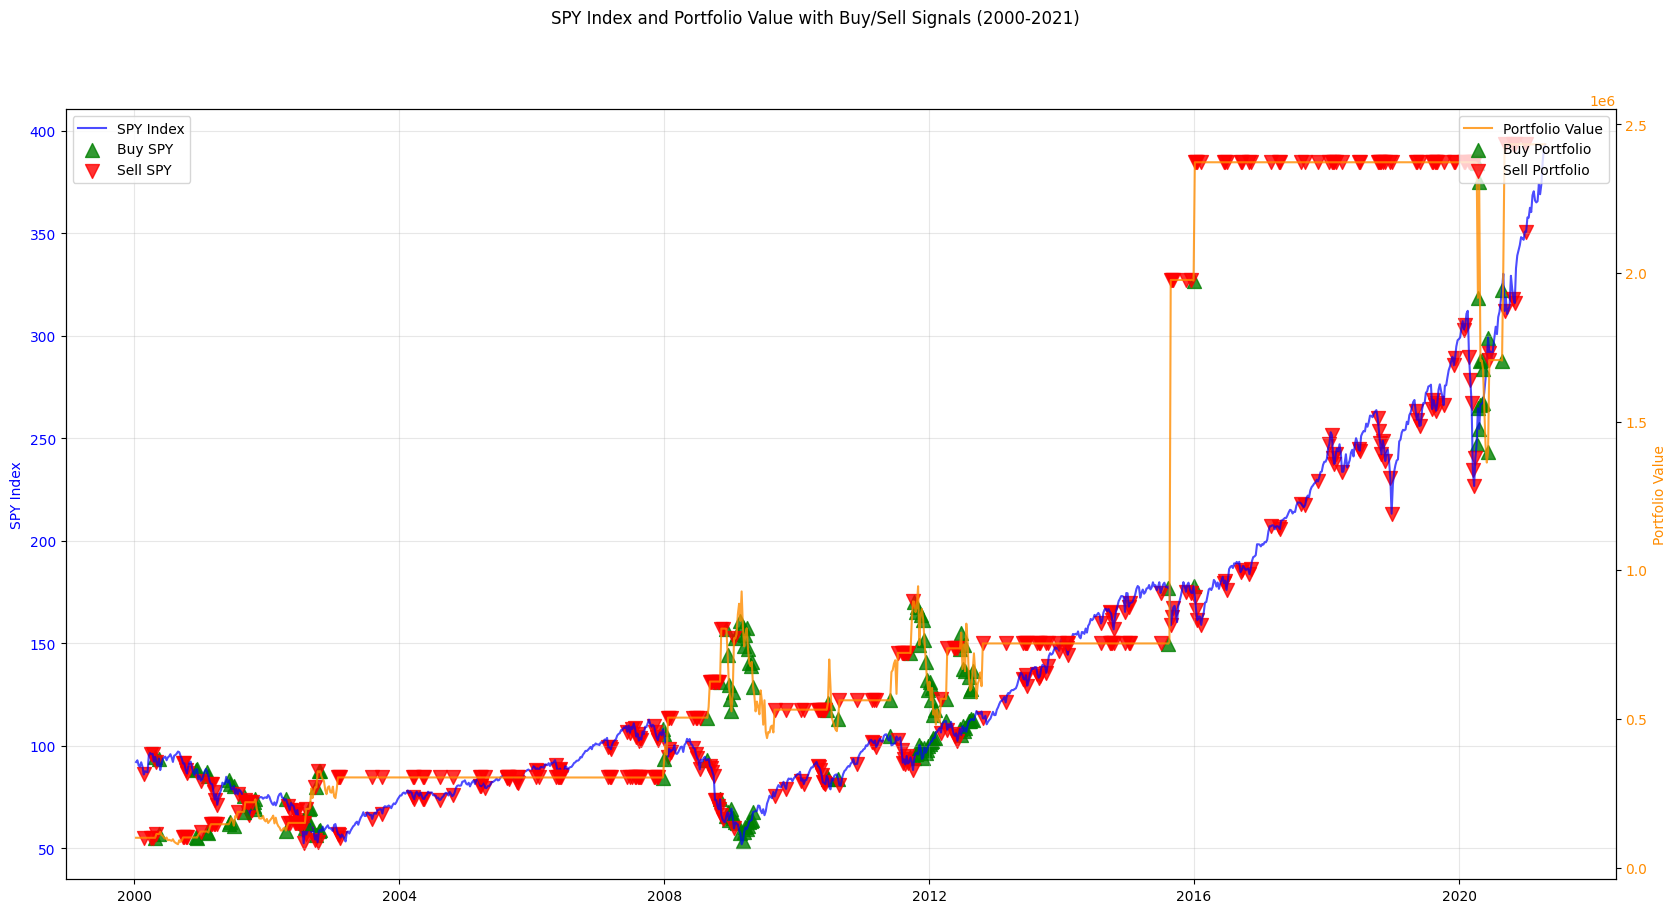

In [11]:

buy_signals = dataset_cleaned[dataset_cleaned['Strategy'] == 'Buy']
sell_signals = dataset_cleaned[dataset_cleaned['Strategy'] == 'Sell']

fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot SPY Index on the first y-axis
ax1.plot(dataset_cleaned['SPY'], label='SPY Index', color='blue', alpha=0.7)
ax1.set_ylabel('SPY Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Buy/Sell signals for SPY
ax1.scatter(buy_signals.index, buy_signals['SPY'], color='green', label='Buy SPY', marker='^', s=100, alpha=0.8)
ax1.scatter(sell_signals.index, sell_signals['SPY'], color='red', label='Sell SPY', marker='v', s=100, alpha=0.8)

#second y-axis for Portfolio Value
ax2 = ax1.twinx()
ax2.plot(dataset_cleaned['Portfolio_Value'], label="Portfolio Value", color='darkorange', alpha=0.8)
ax2.set_ylabel('Portfolio Value', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

#  Buy/Sell signals for Portfolio Value
ax2.scatter(buy_signals.index, dataset_cleaned.loc[buy_signals.index, 'Portfolio_Value'], 
            color='green', label='Buy Portfolio', marker='^', s=100, alpha=0.8)
ax2.scatter(sell_signals.index, dataset_cleaned.loc[sell_signals.index, 'Portfolio_Value'], 
            color='red', label='Sell Portfolio', marker='v', s=100, alpha=0.8)


fig.suptitle("SPY Index and Portfolio Value with Buy/Sell Signals (2000-2021)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


ax1.grid(alpha=0.3)

plt.show()




# Chatbot

In [12]:
# Flask App Initialization
app = Flask(__name__)



# Endpoint to handle chatbot messages
@app.route('/chat', methods=['POST'])
def chat():
    user_message = request.json.get('message', '').strip().lower()
    response = ""

    # Fetch real-time data
    latest_price, real_time_data = fetch_real_time_data("SPY")
    moving_average = calculate_moving_average(real_time_data)

    if latest_price is None or moving_average is None:
        response = "Real-time data is unavailable at the moment. Please try again later."
        return jsonify({'response': response})

    # Simulate anomaly prediction
    anomaly_prob = predict_anomaly(model, latest_price, moving_average)

    # Define real-time strategy
    latest_data = {
        "price": latest_price,
        "moving_average": moving_average,
        "anomaly_prob": anomaly_prob
    }
    strategy = define_real_time_strategy(latest_data)

    if "buy" in user_message:
        if strategy == "Buy":
            response = f"The real-time strategy recommends buying at a price of ${latest_data['price']:.2f}."
        else:
            response = "The real-time strategy does not recommend buying at the moment."
    elif "sell" in user_message:
        if strategy == "Sell":
            response = f"The real-time strategy recommends selling at a price of ${latest_data['price']:.2f}."
        else:
            response = "The real-time strategy does not recommend selling at the moment."
    else:
        response = f"The current real-time strategy is: {strategy}."

    return jsonify({'response': response})

# Endpoint to generate and serve the portfolio graph
@app.route('/graph', methods=['GET'])
def generate_graph():
    # Simulate graph generation for demonstration purposes
    plt.figure(figsize=(10, 6))
    plt.plot([1, 2, 3, 4, 5], [10, 20, 30, 40, 50], label="Portfolio Value")
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    file_path = 'static/portfolio_graph.png'
    plt.savefig(file_path)
    plt.close()

    return send_file(file_path, mimetype='image/png')

# Main HTML interface for the chatbot
@app.route('/')
def index():
    return '''
<!DOCTYPE html>
<html>
<head>
    <title>Investment Strategy Chatbot</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #f8f9fa;
            font-family: Arial, sans-serif;
        }
        .chat-container {
            max-width: 600px;
            margin: 50px auto;
            padding: 20px;
            background: white;
            border-radius: 10px;
            box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);
            display: flex;
            flex-direction: column;
            height: 80vh;
        }
        #chat-box {
            flex-grow: 1;
            overflow-y: auto;
            padding: 10px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 8px;
            background-color: #f9f9f9;
        }
        .message {
            margin: 10px 0;
            display: flex;
            align-items: center;
        }
        .bot-message {
            background: #d1e7dd;
            padding: 10px;
            border-radius: 8px;
            max-width: 75%;
            display: inline-block;
        }
        .user-message {
            background: #f8d7da;
            padding: 10px;
            border-radius: 8px;
            max-width: 75%;
            text-align: right;
            margin-left: auto;
            display: inline-block;
        }
        .input-group {
            display: flex;
        }
        #message {
            flex-grow: 1;
            border-radius: 20px;
            padding: 10px;
            border: 1px solid #ced4da;
        }
        .btn {
            border-radius: 20px;
            margin-left: 10px;
        }
    </style>
</head>
<body>
    <div class="chat-container">
        <h1 class="text-center mb-3">Investment Strategy Chatbot</h1>
        <div id="chat-box"></div>
        <div class="input-group">
            <input type="text" id="message" class="form-control" placeholder="Ask me about buying, selling, or anomalies...">
            <button class="btn btn-primary" onclick="sendMessage()">Send</button>
        </div>
    </div>

    <script>
        async function sendMessage() {
            const userMessage = document.getElementById("message").value.trim();
            if (!userMessage) {
                alert("Please enter a message.");
                return;
            }

            const response = await fetch("/chat", {
                method: "POST",
                headers: { "Content-Type": "application/json" },
                body: JSON.stringify({ message: userMessage })
            });
            const data = await response.json();
            const chatBox = document.getElementById("chat-box");

            chatBox.innerHTML += `
                <div class="message user-message">
                    ${userMessage}
                </div>`;
            chatBox.innerHTML += `
                <div class="message bot-message">
                    ${data.response}
                </div>`;

            document.getElementById("message").value = "";
            chatBox.scrollTop = chatBox.scrollHeight; // Auto-scroll to the latest message
        }
    </script>
</body>
</html>
    '''

# Function to start the Flask app in a separate thread
def run_flask():
    app.run(debug=True, port=5000, use_reloader=False)

# Start the Flask server
if __name__ == '__main__':
    flask_thread = Thread(target=run_flask)
    flask_thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [16/Jan/2025 03:36:06] "GET / HTTP/1.1" 200 -
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_286860/1223480986.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(latest_price)
/tmp/ipykernel_286860/1223480986.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moving_average = float(moving_average)
127.0.0.1 - - [16/Jan/2025 03:36:09] "POST /chat HTTP/1.1" 500 -
Traceback (most recent call last):
  File "/home/ing/Bureau/market_crash_detection/my_new_env/lib/python3.11/site-packages/flask/app.py", line 1536, in __call__
    return self.wsgi_app(environ, start_response)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ing/Bureau/market_crash_detectio